# 01. Data Download and Preprocessing

Author: **Minghang Li, Anna Toidze**


In this Jupyter Notebook download the data and preprocess the provided samples.

**Exercise overview:**<br>
[1. Setup](#setup)<br>
[2. Download](#download)<br>
[3. Data denoising - Amplicon Sequence Variants](#denoising)<br>
[4. Clustering - Operational Taxonomic Units](#clustering)<br>
[5. Troubleshooting](#trouble)<br>



<a id='setup'></a>

## 1. Setup

In [2]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization

%matplotlib inline

In [3]:
# get project root by finding .git folder
root = !git rev-parse --show-toplevel
root = root[0]

# assigning variables throughout the notebook
raw_data_dir = os.path.join(root, "data/raw")
data_dir = os.path.join(root, "data/processed")
vis_dir  = os.path.join(root, "results")

In [4]:
%%bash -s $raw_data_dir $data_dir $vis_dir

mkdir -p "$1" "$2" "$3"
chmod -R +rxw "$1" "$2" "$3"

<a id='download'></a>

## 2. Download data

Donload the data from polybox.

Original data are stored in `<project-root>/data/raw` (please refrain from editting it!).

In [4]:
# this will download the sequence data to <project-root>/data/raw/sequencs.qza
! aria2c --max-connection-per-server="$(nproc)" \
    --allow-overwrite=true \
    -d "$raw_data_dir" \
    "https://polybox.ethz.ch/index.php/s/lCmJYEDg5Xz1FEA/download"


10/22 08:02:41 [NOTICE] Downloading 1 item(s)

10/22 08:02:42 [NOTICE] Allocating disk space. Use --file-allocation=none to disable it. See --file-allocation option in man page for more details.
[#980708 6.4GiB/6.7GiB(96%) CN:5 DL:477MiB]0m]mGiB(95%)]
10/22 08:03:15 [NOTICE] Download complete: ../data/raw/sequences.qza

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
980708|OK  |   291MiB/s|../data/raw/sequences.qza

Status Legend:
(OK):download completed.


In [5]:
# this will download the metadata to <project-root>/data/raw/metadata.tsv
! aria2c --max-connection-per-server="$(nproc)" \
    --allow-overwrite=true \
    -d "$raw_data_dir" \
    "https://polybox.ethz.ch/index.php/s/JrwER5E9kpgGuWd/download"


10/22 08:03:15 [NOTICE] Downloading 1 item(s)

10/22 08:03:15 [NOTICE] Download complete: ../data/raw/metadata.tsv

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
5e13ac|OK  |   290KiB/s|../data/raw/metadata.tsv

Status Legend:
(OK):download completed.


In [6]:
# peek at the data
! qiime tools peek $raw_data_dir/sequences.qza

UUID:        058d7a5b-dd47-427e-b047-e5563adaefee
Type:        SampleData[PairedEndSequencesWithQuality]
Data format: SingleLanePerSamplePairedEndFastqDirFmt


In [7]:
meta = pd.read_csv(f"{raw_data_dir}/metadata.tsv", sep="\t")
meta.head()

,Sample_Name,Patient_ID,Stool_Consistency,Patient_Sex,Sample_Day,Recovery_Day,Cohort_Number
0,EG2580,P042,liquid,F,13,17.0,2
1,EG2559,P043,liquid,M,15,17.0,2
2,EG2537,P042,liquid,F,0,17.0,1
3,EG2518,P043,liquid,M,0,17.0,1
4,EG2490,P030,formed,F,0,NaN,1


In [16]:
meta

,Sample_Name,Patient_ID,Stool_Consistency,Patient_Sex,Sample_Day,Recovery_Day,Cohort_Number
0,EG2580,P042,liquid,F,13,17.0,2
1,EG2559,P043,liquid,M,15,17.0,2
2,EG2537,P042,liquid,F,0,17.0,1
3,EG2518,P043,liquid,M,0,17.0,1
4,EG2490,P030,formed,F,0,NaN,1
...,...,...,...,...,...,...,...
97,EG2608,P034,formed,F,0,18.0,1
98,EG2591,P017,liquid,M,0,17.0,1
99,EG0141,P032,liquid,F,0,21.0,1
100,EG0031,P021,formed,M,20,24.0,2


In [26]:
# Identify the Patient_IDs with a count of 2
true_patient_ids = meta.Patient_ID.value_counts()[meta.Patient_ID.value_counts() == 2].index

# Filter the meta table to include only rows with these Patient_IDs
filtered_meta = meta[meta.Patient_ID.isin(true_patient_ids)]

# Display the filtered meta table
filtered_meta

,Sample_Name,Patient_ID,Stool_Consistency,Patient_Sex,Sample_Day,Recovery_Day,Cohort_Number
0,EG2580,P042,liquid,F,13,17.0,2
1,EG2559,P043,liquid,M,15,17.0,2
2,EG2537,P042,liquid,F,0,17.0,1
3,EG2518,P043,liquid,M,0,17.0,1
5,EG2473,P055,semi-formed,M,20,22.0,2
...,...,...,...,...,...,...,...
96,EG2638,P017,semi-formed,M,12,17.0,2
97,EG2608,P034,formed,F,0,18.0,1
98,EG2591,P017,liquid,M,0,17.0,1
99,EG0141,P032,liquid,F,0,21.0,1


<a id='denoising'></a>

## 3. Data Denoising - Amplicon Sequence Variants

### Information on provided datasets

1. **Sequences**: The sequences originate from the V3-V4 region of the 16S rRNA gene and were sequenced on an Illumina MiSeq machine. The sequence files contain **demultiplexed** **paired-end** sequences and are provided as a QIIME 2 artifact (semantic type: `SampleData[PairedEndSequencesWithQuality]`).
  - Forward primer: `ACTCCTRCGGGAGGCAGCAG` (len: **20**)
  - Reverse primer: `GGACTACHVGGGTATCTAATCCTGTT` (len: **26**)
2. **Sample metadata**: The metadata table contains additional information on each collected sample. Each row represents a unique sample that can be identified with its unique `Sample_ID`. The remaining columns depict health data of the patient. All date-related values are given **relative to the day of abduction** e.g. Sample_Day of 13 means 13 days post-abduction

According to the information on the provided data:

- If use `dada2` to denoise data, we should use `dada2 denoise-paired` to denoise data
- If use `deblur`, we probably need to join the reads after qc.
- We probably need to trim the primers before denoising.

### 3.3.1. Data inspection

Use the `demux summarize` command to get a visual summary of all our samples.

In [16]:
! qiime demux summarize \
    --i-data $raw_data_dir/sequences.qza \
    --o-visualization $data_dir/sequences.qzv

Saved Visualization to: ../data/processed/sequences.qzv


In [8]:
Visualization.load(f"{data_dir}/sequences.qzv")

<visualization: Visualization uuid: 2d4cbc57-79fd-4108-ada1-8dcc8cefe099>

### 3.2 Primer trimming

Use `cutadapt trim-paired` to remove adapter sequences

In [191]:
! qiime cutadapt trim-paired \
    --i-demultiplexed-sequences $raw_data_dir/sequences.qza \
    --p-front-f ACTCCTRCGGGAGGCAGCAG \
    --p-front-r GGACTACHVGGGTATCTAATCCTGTT \
    --o-trimmed-sequences $data_dir/sequences_trimmed.qza

Saved SampleData[PairedEndSequencesWithQuality] to: ../data/processed/sequences_trimmed.qza


In [192]:
! qiime demux summarize \
    --i-data $data_dir/sequences_trimmed.qza \
    --o-visualization $data_dir/sequences_trimmed.qzv

Saved Visualization to: ../data/processed/sequences_trimmed.qzv


In [5]:
Visualization.load(f"{data_dir}/sequences_trimmed.qzv")

<visualization: Visualization uuid: 1529a3c2-ae4e-45c1-afee-9c2403d5b16f>

### 3.3. Sequencing quality-based truncation parameter selection

First, load the statistics in `sequences_trimmed.qzv`

In [6]:
# To inspect truncate & trim

qza = f"{data_dir}/sequences_trimmed.qzv"
a = !unzip -o $qza
digest = a[1].split('/')[0].replace("  inflating: ","")
fname_fwd = os.path.join(digest, "data/forward-seven-number-summaries.tsv")
fname_rev = os.path.join(digest, "data/reverse-seven-number-summaries.tsv")
fwd = pd.read_csv(fname_fwd, sep="\t", index_col=[0])
rev = pd.read_csv(fname_rev, sep="\t", index_col=[0])
!rm -r $digest

We want to truncate at a position where the quality scores start to decline consistantly.

In [10]:
def choose_truncation_site(df, score_median=30, score_q1=25, rev=False):
    """
    Choose a truncation site `p` based on the following criteria
    1. all meidan q-score before `p` >= score_median
    2. average lower quatile (q1) q-score after `p` < score_q1
    3. if rev=False, take the smallest position that satisfies 1. and 2. (more stringent)
       otherwise, take the largest position that satisfies 1. and 2.
    """
    def _is_valid_truncation_site(df, col):
        # 4th row 50% quantile
        crit1 = np.all(df.iloc[4, :col] >= score_median)
        # 3rd row 25% quantile
        crit2 = df.iloc[3, col:].mean() < score_q1
        return crit1 and crit2

    it = range(len(df.columns))
    if rev:
        it = range(len(df.columns), 0, -1)
    for i in it:
        # return the first valid truncation site
        if _is_valid_truncation_site(df, i):
            return i


In [5]:
# def choose_truncation_site_other(df, score_median=30, score_q1 = 25):
#     # Go over each position in the read (each column)
#     for i in range(len(df.columns)):
#         # If either condition breaks --> return truncation length
#         if (df.iloc[3, i] < score_q1  # 3rd row (25% quantile) < score_q1
#             or df.iloc[4, i] < score_median):   # 4th row (50% quantile) < score_q1
#             return(i)

In [6]:
def visualize_truncation(
    df, truncate_size=200, figsize=(25, 5), color="b", save=False, save_path=None,
    score_median=30, score_q1 = 25
):
    """
    Visualize truncation size for sequence quality control
    """
    ## TODO: also visualize trimming
    # create figure
    fig, ax = plt.subplots(figsize=figsize)

    # create boxplot
    palette = {}
    for i in df.columns:
        if int(i) <= truncate_size:
            palette[i] = color
        else:
            palette[i] = "gray"

    bxpstats = df.iloc[1:].to_dict()
    # rename keys: "50%" -> "med", "25%" -> "q1", "75%" -> "q3"
    #              "9%" -> "whislo", "91%" -> "whishi"
    bxpstats = [{
            "med": v["50%"],
            "q1": v["25%"],
            "q3": v["75%"],
            "whislo": v["9%"],
            "whishi": v["91%"],
            "fliers": [v["2%"],v["98%"]]
        }
        for k, v in bxpstats.items()
    ]
    bxplot = ax.bxp(bxpstats, patch_artist=True)
    for i, patch in enumerate(bxplot['boxes']):
        patch.set_facecolor(color if i < truncate_size else "gray")
    
    # get y axis range
    y_min, y_max = ax.get_ylim()

    # add vertical line for truncation size
    ax.axvline(x=truncate_size, color="r", linestyle="--")
    ax.text(
        truncate_size + 2,
        (y_max + y_min) // 2,
        f"Truncate size: {truncate_size}",
        color="red",
        fontsize=24,
        # fontweight="bold",
        bbox=dict(facecolor="white", alpha=0.5),
    )
    
    # add a shaded area for everything after the truncation size
    ax.axvspan(truncate_size, len(df.columns), color="gray", alpha=0.5, zorder=-1)

    # add a x line for q score, put it at the bottom layer
    ax.axhline(y=score_median, color="black", linestyle="--", zorder=-233)

    # text for q score
    ax.text(
        0,
        score_median,
        f"Q{score_median}",
        color="black",
        fontsize=18,
        fontweight="bold",
        bbox=dict(facecolor="white", alpha=0.5),
    )

    # rotate x-axis labels
    ax.set_xticklabels(df.columns,rotation=90, fontsize = 5.75)

    # add x, y labels
    ax.set_xlabel("Sequence base position", fontsize=18)
    ax.set_ylabel("Quality score", fontsize=18)

    # tight layout, no space between boxes
    fig.tight_layout()

    # save figure
    if save:
        fig.savefig(save_path)


I'm using the following criterion to programmatically choose truncate position `p`:

* The positions before `p` all have median q-score > 30
* The positions after `p` have average 25th percentile q-score < 25

Then we choose the lowest position that satisfies both criteria.

In [12]:
trunc_len_f = choose_truncation_site(fwd, score_median=30, score_q1=25, rev=True)
trunc_len_r = choose_truncation_site(rev, score_median=30, score_q1=25, rev=True)

In [13]:
print(f"Forward truncation size: {trunc_len_f};\n"
      f"Reverse truncation size: {trunc_len_r}.")

Forward truncation size: 236;
Reverse truncation size: 200.


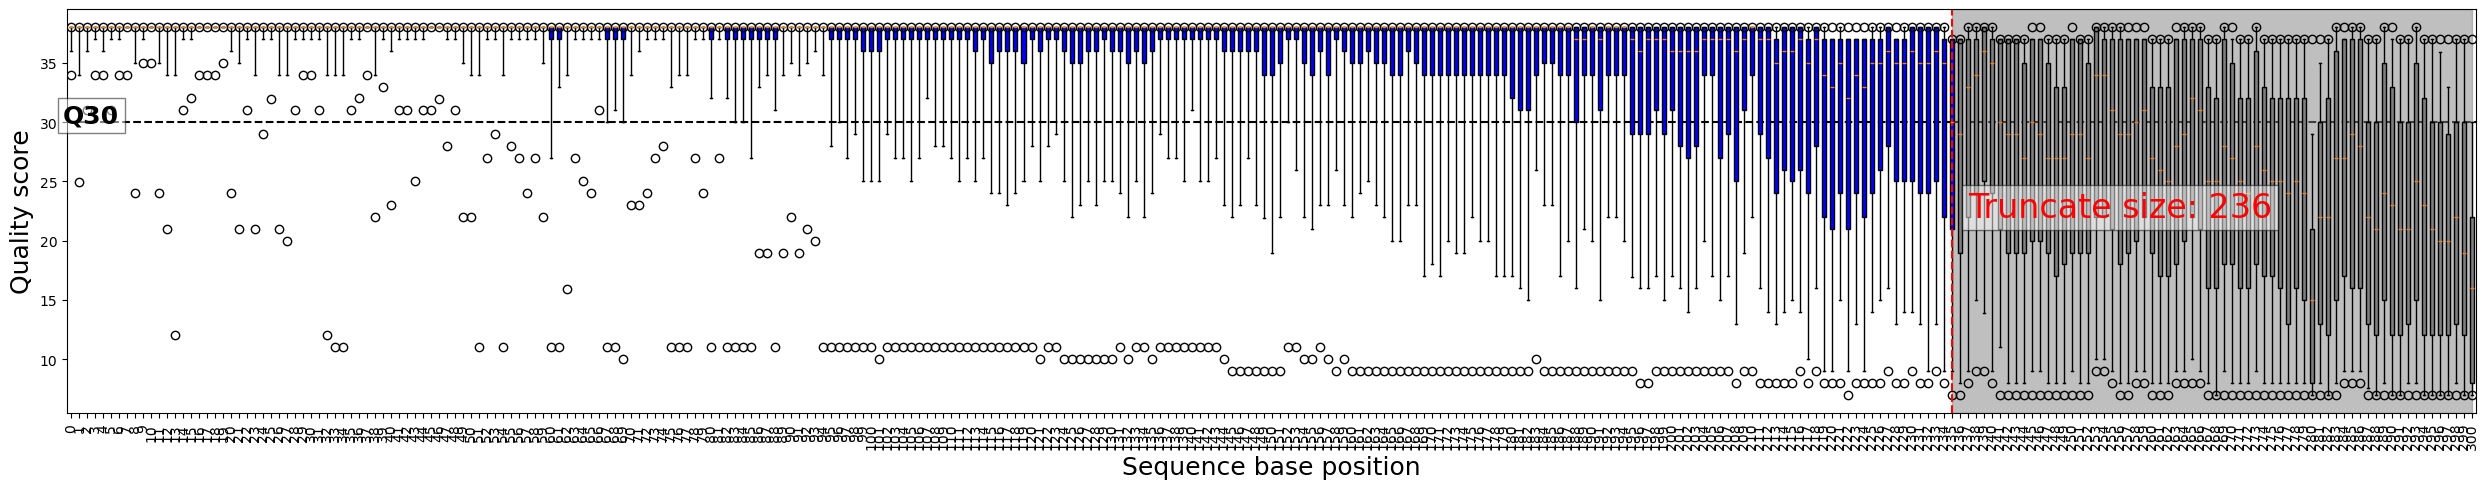

In [34]:
visualize_truncation(
    fwd, truncate_size=trunc_len_f, save=True, save_path=f"{vis_dir}/fwd_truncation_visualization.png"
)

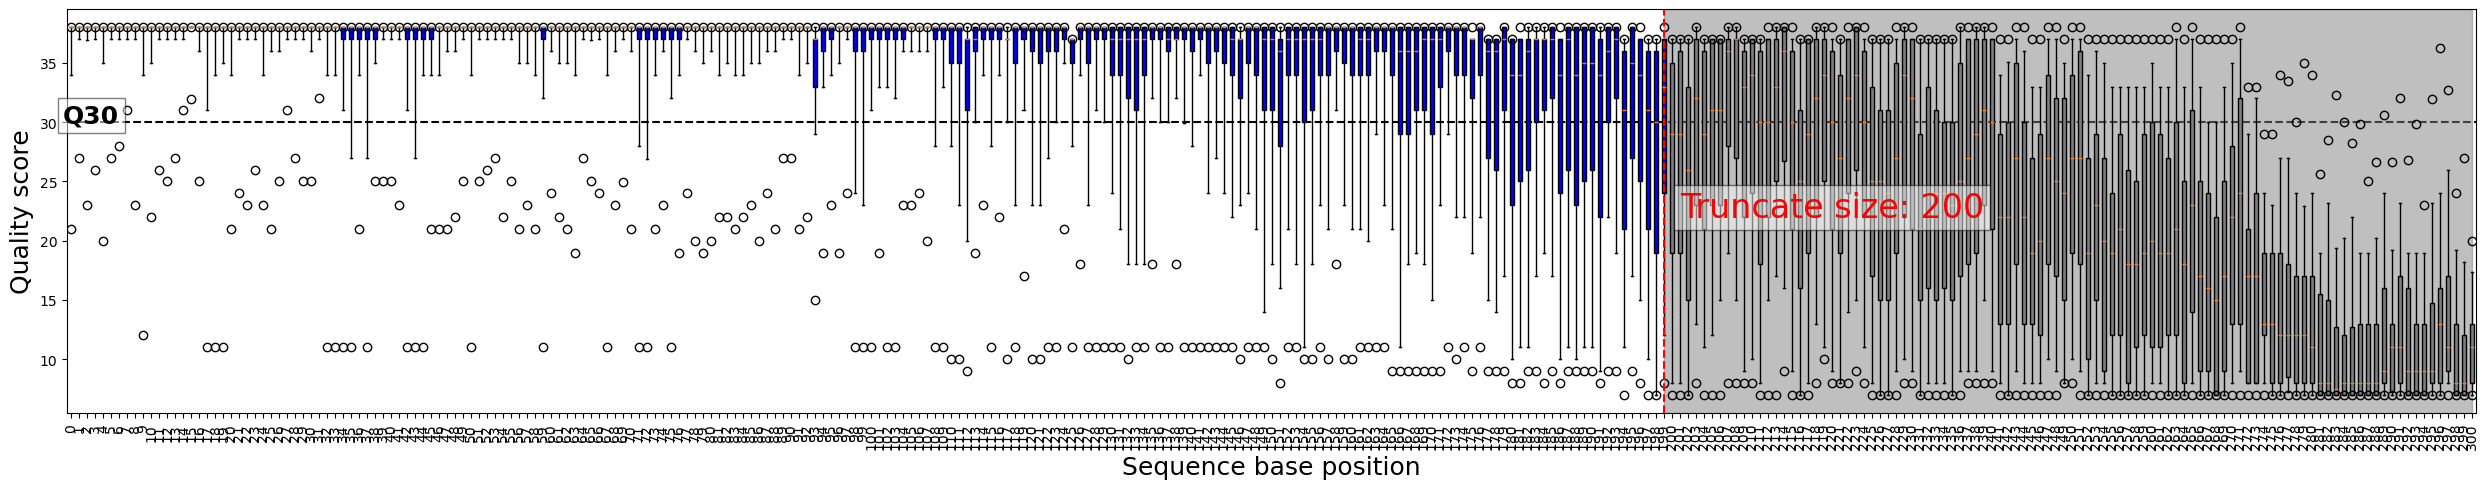

In [35]:
visualize_truncation(
    rev, truncate_size=trunc_len_r, save=True, save_path=f"{vis_dir}/rev_truncation_visualization.png"
)

### 3.4. Real data denoising

Use `dada2 denoise-paired` to denoise data using the selected parameters.

(As the data is very huge, running more than 4 threads will get the program OOM killed)

In [194]:
! qiime dada2 denoise-paired \
  --i-demultiplexed-seqs $data_dir/sequences_trimmed.qza \
  --p-trunc-len-f 236  \
  --p-trunc-len-r 200 \
  --p-n-threads 4 \
  --o-table $data_dir/table.qza \
  --o-representative-sequences $data_dir/rep-seqs.qza \
  --o-denoising-stats $data_dir/denoising-stats.qza

Saved FeatureTable[Frequency] to: ../data/processed/table.qza
Saved FeatureData[Sequence] to: ../data/processed/rep-seqs.qza
Saved SampleData[DADA2Stats] to: ../data/processed/denoising-stats.qza


#### 3.5. Visualization after denoising

In [197]:
! qiime feature-table summarize \
  --i-table $data_dir/table.qza \
  --o-visualization $data_dir/table.qzv

Saved Visualization to: ../data/processed/table.qzv


In [198]:
Visualization.load(f"{data_dir}/table.qzv")

<visualization: Visualization uuid: 92c13283-060e-4ac5-a89b-114aeb629c17>

In [5]:
! qiime tools view $data_dir/table.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

| Summary Statistic  | Value      |
|--------------------|------------|
| Number of samples  | 102        |
| Number of features | 2,001      |
| Total frequency    | 15,386,341 |

In [199]:
! qiime feature-table tabulate-seqs \
  --i-data $data_dir/rep-seqs.qza \
  --o-visualization $data_dir/rep-seqs.qzv

Saved Visualization to: ../data/processed/rep-seqs.qzv


In [200]:
Visualization.load(f"{data_dir}/rep-seqs.qzv")

<visualization: Visualization uuid: c2d76e59-8834-40f6-aa15-efb85830ab8e>

In [18]:
! qiime tools view $data_dir/rep-seqs.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

There are 2001 unique features. 

| Sequence Count | Min Length | Max Length | Mean Length | Range | Standard Deviation |
|----------------|------------|------------|-------------|-------|--------------------|
| 2001           | 236        | 424        | 407.33      | 188   | 17.93              |



| Percentile:    | 2%  | 9%  | 25% | 50% | 75% | 91% | 98% |
|----------------|-----|-----|-----|-----|-----|-----|-----|
| Length* (nts): | 397 | 398 | 398 | 401 | 423 | 423 | 424 |

In [ ]:
! qiime metadata tabulate \
  --m-input-file $data_dir/denoising-stats.qza \
  --o-visualization $data_dir/denoising-stats.qzv

Saved Visualization to: ../data/processed/denoising-stats.qzv


In [ ]:
Visualization.load(f"{data_dir}/denoising-stats.qzv")

<visualization: Visualization uuid: abe4be1e-f1e8-4174-803f-a78bec53d144>

In [14]:
! qiime tools view $data_dir/denoising-stats.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

The denoising statistics indicate successful processing of most samples. Samples with very low input reads (fewer than 1240 reads) were largely filtered out and not merged, whereas samples with input reads exceeding 100,000 retained at least 60% of their reads.

As shown in the table below, which summarizes the first 14 samples sorted by the percentage of retained reads, the first 8 samples had a low number of input reads, exhibited a lower percentage of retained reads, and had a reduced percentage of merged reads. For samples with input reads greater than 100,000, the lowest observed percentage of input reads merged was 56.93% (Sample EG0732).

| sample-id #q2:types | input numeric | filtered numeric | percentage of input passed filter numeric | denoised numeric | merged numeric | percentage of input merged numeric | non-chimeric numeric | percentage of input non-chimeric numeric |
|---------------------|---------------|------------------|-------------------------------------------|------------------|----------------|------------------------------------|----------------------|------------------------------------------|
| EG2473              | 1240          | 137              | 11.05                                     | 95               | 79             | 6.37                               | 79                   | 6.37                                     |
| EG1153              | 1129          | 160              | 14.17                                     | 134              | 79             | 7                                  | 79                   | 7                                        |
| EG1772              | 858           | 124              | 14.45                                     | 92               | 74             | 8.62                               | 74                   | 8.62                                     |
| EG0968              | 971           | 150              | 15.45                                     | 102              | 82             | 8.44                               | 82                   | 8.44                                     |
| EG1527              | 324           | 51               | 15.74                                     | 20               | 7              | 2.16                               | 7                    | 2.16                                     |
| EG2518              | 955           | 177              | 18.53                                     | 117              | 73             | 7.64                               | 73                   | 7.64                                     |
| EG2537              | 526           | 116              | 22.05                                     | 89               | 75             | 14.26                              | 75                   | 14.26                                    |
| EG2226              | 162           | 39               | 24.07                                     | 34               | 25             | 15.43                              | 25                   | 15.43                                    |
| EG0732              | 218323        | 129908           | 59.5                                      | 129295           | 124288         | 56.93                              | 101918               | 46.68                                    |
| EG1431              | 143025        | 96187            | 67.25                                     | 95680            | 93683          | 65.5                               | 81208                | 56.78                                    |
| EG0767              | 160558        | 109574           | 68.25                                     | 108938           | 105275         | 65.57                              | 81147                | 50.54                                    |
| EG0024              | 248466        | 170806           | 68.74                                     | 170377           | 165425         | 66.58                              | 142614               | 57.4                                     |
| EG2435              | 310392        | 214871           | 69.23                                     | 213604           | 203670         | 65.62                              | 170680               | 54.99                                    |
| EG0497              | 288180        | 201018           | 69.75                                     | 199896           | 194131         | 67.36                              | 158376               | 54.96                                    |

<a id='clustering'></a>


# 4. Clustering - Operational Taxonomic Units

Even though OTU clustering is an outdated method, we still tried to use the method. We first quality checked the raw reads by removing low-quality and erroneous sequences, dereplciated the reads, and eliminated chimeric sequences. Adterwards, we created OTUs-clusters of similar sequences—using a specified identity threshold. 

** We have done the following section, just for the sake of practice, so that the results from the OTU clustering will not be used further down in the analysis. **

#### 4.1. Quality Filtering

Here, we used a quality threshold of Q=30 and minimum length that a sequence read can be following truncation, as 0.9 (given as a fraction of the input sequence length).

In [56]:
! qiime quality-filter q-score \
    --i-demux $raw_data_dir/sequences.qza \
    --p-min-quality 30 \
    --p-min-length-fraction 0.9 \
    --o-filtered-sequences $data_dir/demux_seqs_qc.qza \
    --o-filter-stats $data_dir/demux_seqs_qc_stats.qza

Saved SampleData[SequencesWithQuality] to: ../data/processed/demux_seqs_qc.qza
Saved QualityFilterStats to: ../data/processed/demux_seqs_qc_stats.qza


In [5]:
! qiime demux summarize \
    --i-data $data_dir/demux_seqs_qc.qza \
    --o-visualization $data_dir/demux_seqs_qc.qzv

Saved Visualization to: ../data/processed/demux_seqs_qc.qzv


In [9]:
! qiime tools view $data_dir/sequences.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

In [6]:
! qiime tools view $data_dir/demux_seqs_qc.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

Before filtering there were 25 249 775 + 25 249 775 = 50 499 550 reads. After the filtering, 8 370 355 were left (16.6 %). To retain higher number of reads, we could have maybe relaxed the `--p-min-length-fraction` and left it at default value of 0.75. While the median read length stayed the same, on the lower percentiles the read length was less than before filtering. 

Before filtering, we see a rapid decline in quality scores, especially after 160 bases, with high variability and many low-quality bases. After filtering more consistent high-quality scores across the sequence length can be seen, indicating that low-quality bases were effectively removed during filtering.

#### 4.2. Dereplication

Dereplication using `vsearch` plugin:

This action will produce two artifacts:
- `FeatureData[Sequence]` containing a list of unique DNA sequences
- `FeatureTable[Frequency]` containing a mapping of the dereplicated sequences to samples

In [57]:
! qiime vsearch dereplicate-sequences \
    --i-sequences $data_dir/demux_seqs_qc.qza \
    --o-dereplicated-sequences $data_dir/demux_seqs_derep.qza \
    --o-dereplicated-table $data_dir/demux_table_derep.qza

Saved FeatureTable[Frequency] to: ../data/processed/demux_table_derep.qza
Saved FeatureData[Sequence] to: ../data/processed/demux_seqs_derep.qza


#### 4.3. Chimera removal

Remove chimeric sequences from the data using another action from the `vsearch` plugin.


In [24]:
! qiime vsearch uchime-denovo \
    --i-sequences $data_dir/demux_seqs_derep.qza \
    --i-table $data_dir/demux_table_derep.qza \
    --o-chimeras $data_dir/demux_chimeras.qza \
    --o-nonchimeras $data_dir/demux_nonchimeras.qza \
    --o-stats $data_dir/demux_chimera_stats.qza

Saved FeatureData[Sequence] to: ../data/processed/demux_chimeras.qza
Saved FeatureData[Sequence] to: ../data/processed/demux_nonchimeras.qza
Saved UchimeStats to: ../data/processed/demux_chimera_stats.qza


In [25]:
! qiime feature-table filter-features \
    --i-table $data_dir/demux_table_derep.qza \
    --m-metadata-file $data_dir/demux_nonchimeras.qza \
    --o-filtered-table $data_dir/demux_table_filtered.qza

! qiime feature-table filter-seqs \
    --i-data $data_dir/demux_seqs_derep.qza \
    --m-metadata-file $data_dir/demux_nonchimeras.qza \
    --o-filtered-data $data_dir/demux_seqs_filtered.qza

! qiime feature-table summarize \
    --i-table $data_dir/demux_table_filtered.qza \
    --o-visualization $data_dir/demux_table_filtered.qzv

Saved FeatureTable[Frequency] to: ../data/processed/demux_table_filtered.qza
Saved FeatureData[Sequence] to: ../data/processed/demux_seqs_filtered.qza
Saved Visualization to: ../data/processed/demux_table_filtered.qzv


In [10]:
! qiime tools view $data_dir/demux_table_filtered.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

#### 4.4. _De novo_ clustering

We do not have a reference database, so we cluster _De novo_. We clustered at 91 % identity.

In [27]:
! qiime vsearch cluster-features-de-novo \
    --i-table $data_dir/demux_table_filtered.qza \
    --i-sequences $data_dir/demux_seqs_filtered.qza \
    --p-perc-identity 0.91 \
    --p-threads 8 \
    --o-clustered-table $data_dir/demux_table_de_novo_91.qza \
    --o-clustered-sequences $data_dir/demux_rep_set_de_novo_91.qza

Saved FeatureTable[Frequency] to: ../data/processed/demux_table_de_novo_91.qza
Saved FeatureData[Sequence] to: ../data/processed/demux_rep_set_de_novo_91.qza


In [40]:
meta = pd.read_csv(f"{raw_data_dir}/metadata.tsv", sep="\t")
meta.rename(columns={"Sample_Name": "sample-id"}, inplace=True)
meta.to_csv(f"{data_dir}/metadata.tsv", sep="\t", index=False)


In [41]:
! qiime feature-table tabulate-seqs \
    --i-data $data_dir/demux_rep_set_de_novo_91.qza \
    --o-visualization $data_dir/demux_rep_set_de_novo_91.qzv

! qiime feature-table summarize \
    --i-table $data_dir/demux_table_de_novo_91.qza \
    --m-sample-metadata-file $data_dir/metadata.tsv \
    --o-visualization $data_dir/demux_table_de_novo_91.qzv

Saved Visualization to: ../data/processed/demux_rep_set_de_novo_91.qzv
Saved Visualization to: ../data/processed/demux_table_de_novo_91.qzv


In [11]:
! qiime tools view $data_dir/demux_rep_set_de_novo_91.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

In [12]:
! qiime tools view $data_dir/demux_table_de_novo_91.qzv

Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

*Before clustering*:

| Summary Statistic  | Value     |
|--------------------|-----------|
| Number of samples  | 102       |
| Number of features | 1,609,702 |
| Total frequency    | 6,781,031 |


*After clustering*:
| Summary Statistic  | Value     |
|--------------------|-----------|
| Number of samples  | 102       |
| Number of features | 1,027     |
| Total frequency    | 6,781,031 |

As the features were clustered (grouped) into OTUs based on 91 \% sequence identity, the number of features drastically decreased.


**ALL DEMUX FILES WERE TOO LARGE FOR GITHUB, SO NOT UPLOADED.**

<a id='trouble'></a>

## 5 - Troubleshooting

### Other parameters

We also tried other truncation lengths, however, the denoising results were worse than the criteria above. However, we still kept the code below to showcase what we tried.

#### Strict(er) parameters

I'm using the following criterion to programmatically choose truncate position `p`:

* The positions before `p` all have median q-score > 30
* The positions before `p` all have 25th percentile q-score > 25

In [ ]:
# trunc_len_f = choose_truncation_site_other(fwd)
# trunc_len_r = choose_truncation_site_other(rev)

In [ ]:
# print(f"Forward truncation size: {trunc_len_f};\n"
#       f"Reverse truncation size: {trunc_len_r}.")

Forward truncation size: 213;
Reverse truncation size: 180.


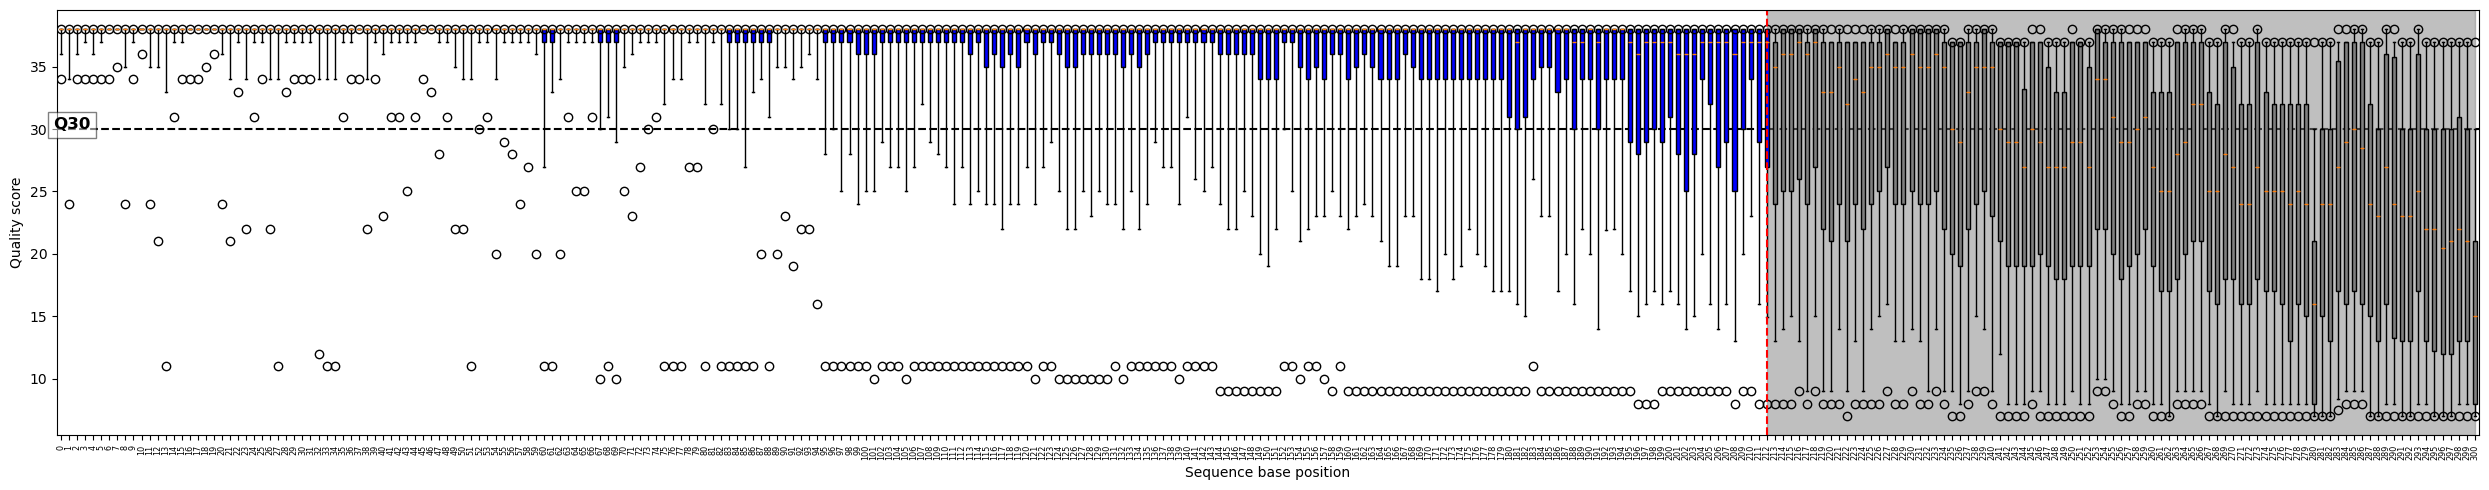

In [ ]:
# visualize_truncation(
#     fwd, truncate_size=trunc_len_f, save=True, save_path=f"{vis_dir}/fwd_truncation_visualization_strict.png"
# )

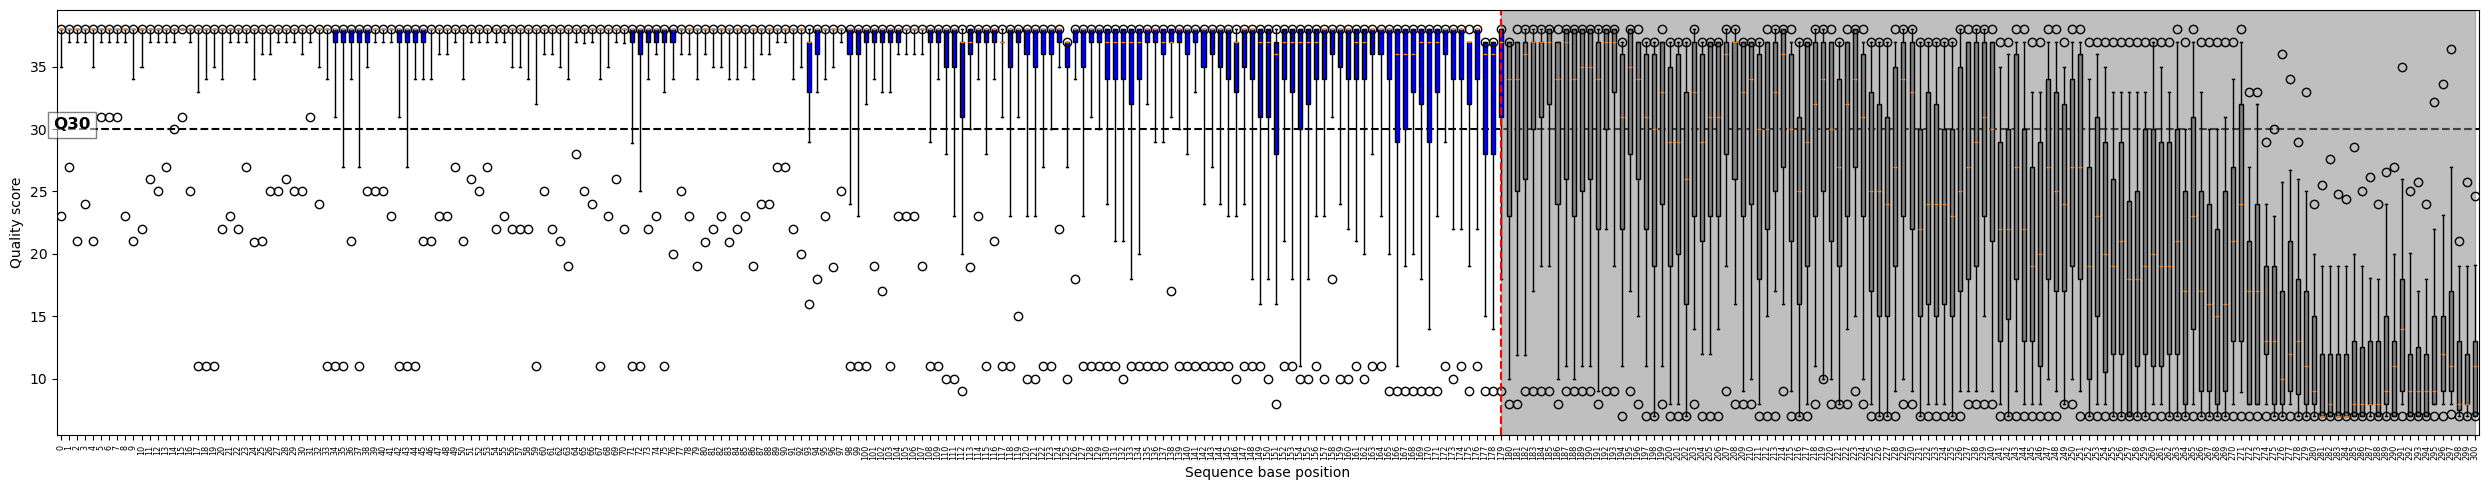

In [ ]:
# visualize_truncation(
#     rev, truncate_size=trunc_len_r, save=True, save_path=f"{vis_dir}/rev_truncation_visualization_strict.png"
# )

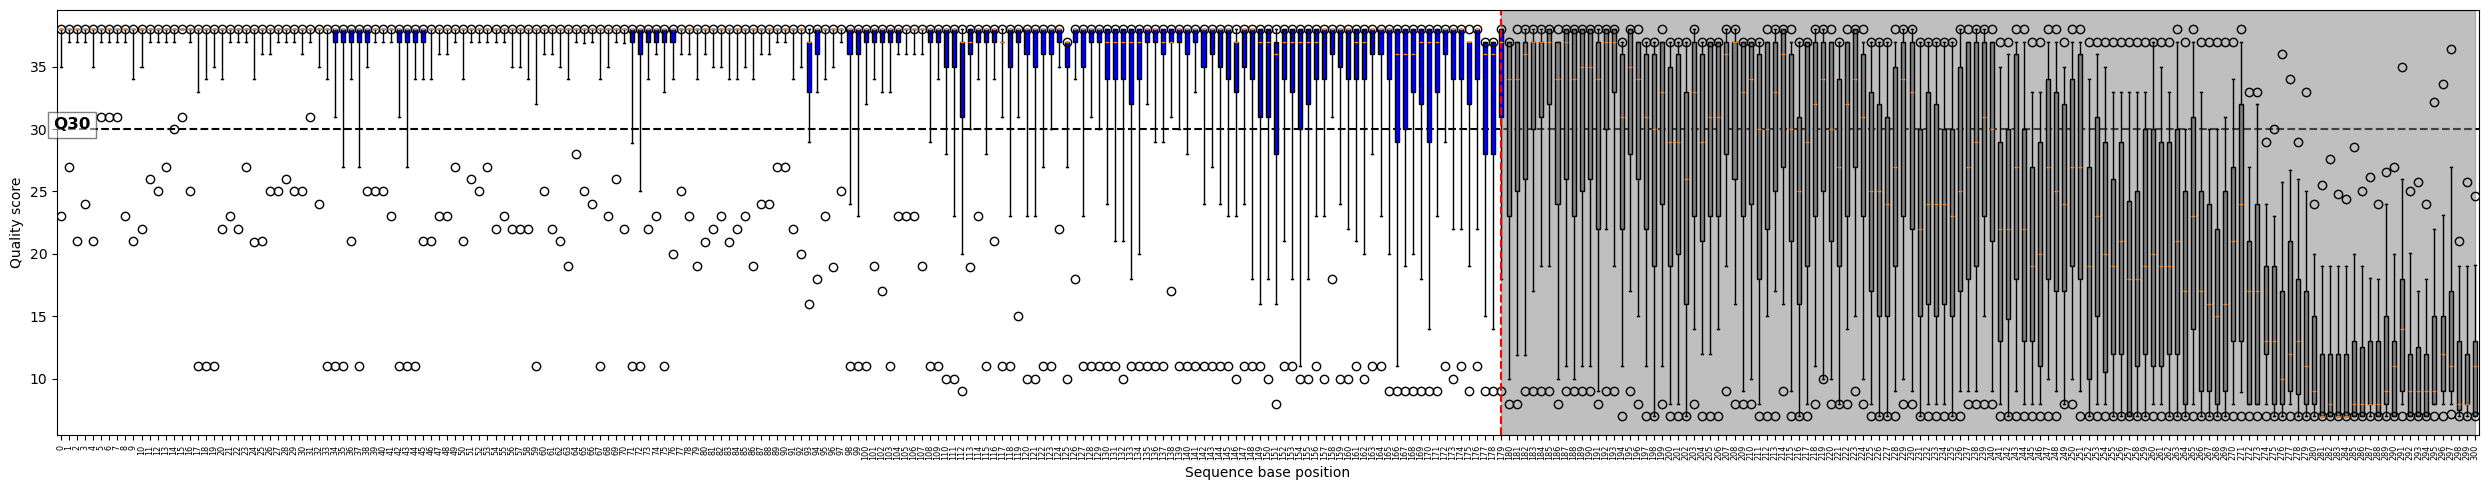

In [ ]:
# visualize_truncation(
#     rev, truncate_size=trunc_len_r, save=True, save_path=f"{vis_dir}/rev_truncation_visualization_strict.png"
# )

#### Mild(er) parameters

I'm using the following criterion to programmatically choose truncate position `p`:

* The positions before `p` all have median q-score > 25
* The positions before `p` all have 25th percentile q-score > 20

In [ ]:
# trunc_len_f = choose_truncation_site_other(fwd, score_median=25, score_q1 = 20)
# trunc_len_r = choose_truncation_site_other(rev, score_median=25, score_q1 = 20)

In [ ]:
# print(f"Forward truncation size: {trunc_len_f};\n"
#       f"Reverse truncation size: {trunc_len_r}.")

Forward truncation size: 236;
Reverse truncation size: 198.


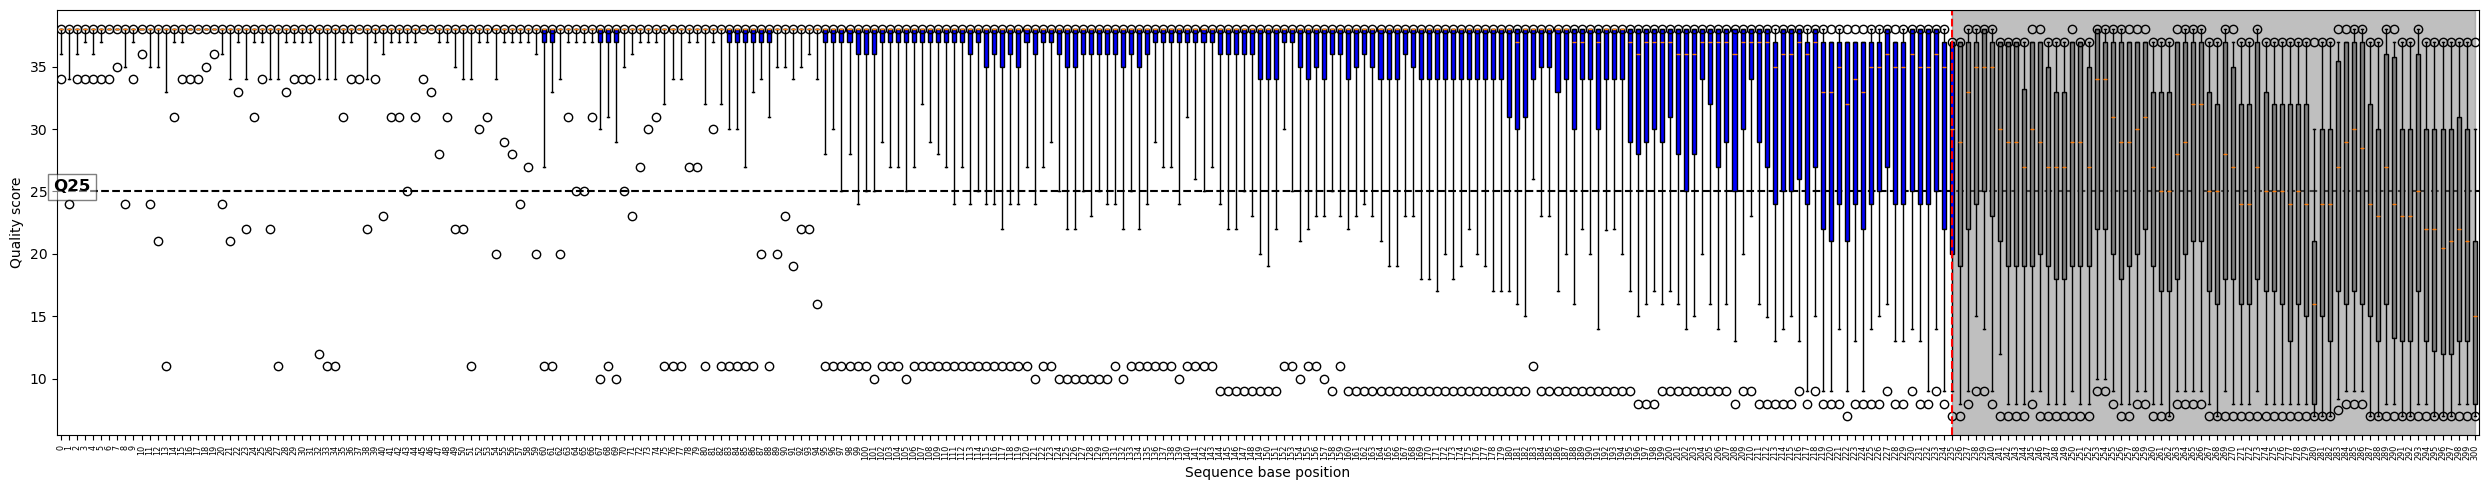

In [ ]:
# visualize_truncation(
#     fwd, truncate_size=trunc_len_f, save=True, save_path=f"{vis_dir}/fwd_truncation_visualization_mild.png",
#     score_median=25, score_q1 = 20
# )

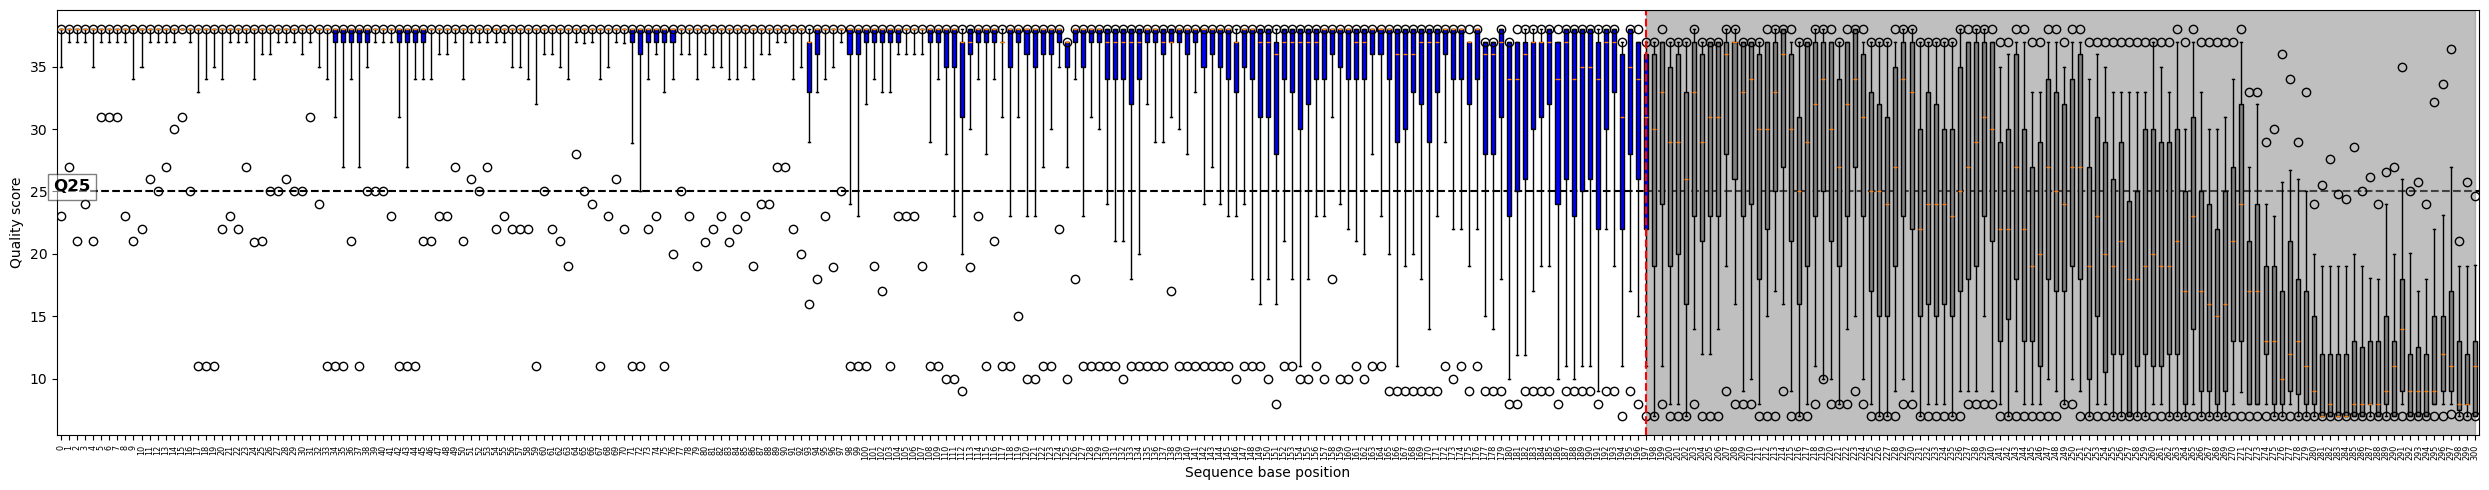

In [ ]:
# visualize_truncation(
#     rev, truncate_size=trunc_len_r, save=True, save_path=f"{vis_dir}/rev_truncation_visualization_mild.png",
#     score_median=25, score_q1 = 20
# )

In [ ]:
## Strict parameters
# ! qiime dada2 denoise-paired \
#   --i-demultiplexed-seqs $data_dir/sequences_trimmed.qza \
#   --p-trunc-len-f 213  \
#   --p-trunc-len-r 180 \
#   --p-n-threads 4 \
#   --o-table $data_dir/table_strict.qza \
#   --o-representative-sequences $data_dir/rep-seqs_strict.qza \
#   --o-denoising-stats $data_dir/denoising-stats_strict.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_strict.qza
Saved FeatureData[Sequence] to: ../data/processed/rep-seqs_strict.qza
Saved SampleData[DADA2Stats] to: ../data/processed/denoising-stats_strict.qza


In [ ]:
## Mild parameters
# ! qiime dada2 denoise-paired \
#   --i-demultiplexed-seqs $data_dir/sequences_trimmed.qza \
#   --p-trunc-len-f 236  \
#   --p-trunc-len-r 198 \
#   --p-n-threads 4 \
#   --o-table $data_dir/table_mild.qza \
#   --o-representative-sequences $data_dir/rep-seqs_mild.qza \
#   --o-denoising-stats $data_dir/denoising-stats_mild.qza

Saved FeatureTable[Frequency] to: ../data/processed/table_mild.qza
Saved FeatureData[Sequence] to: ../data/processed/rep-seqs_mild.qza
Saved SampleData[DADA2Stats] to: ../data/processed/denoising-stats_mild.qza


##### Strict and mild score denoising

This is not used in further analysis as after denoising, theas the merging percentages were lower than above, which meant that the reads were too truncated.

In [ ]:
# ! qiime feature-table summarize \
#   --i-table $data_dir/table_strict.qza \
#   --o-visualization $data_dir/table_strict.qzv

Saved Visualization to: ../data/processed/table_strict.qzv


In [ ]:
# Visualization.load(f"{data_dir}/table_strict.qzv")

<visualization: Visualization uuid: 53754529-1cf9-4e9d-a4fe-02f7545c772b>

In [ ]:
# ! qiime feature-table tabulate-seqs \
#   --i-data $data_dir/rep-seqs_strict.qza \
#   --o-visualization $data_dir/rep-seqs_strict.qzv

Saved Visualization to: ../data/processed/rep-seqs_strict.qzv


In [ ]:
# Visualization.load(f"{data_dir}/rep-seqs_strict.qzv")

<visualization: Visualization uuid: 4bca6c33-3a3d-46be-876d-a5461eb21ce0>

In [ ]:
# ! qiime metadata tabulate \
#   --m-input-file $data_dir/denoising-stats_strict.qza \
#   --o-visualization $data_dir/denoising-stats_strict.qzv

Saved Visualization to: ../data/processed/denoising-stats_strict.qzv


In [ ]:
# Visualization.load(f"{data_dir}/denoising-stats_strict.qzv")

<visualization: Visualization uuid: 594ad34b-061a-4ab9-a0dd-14d437b03bd9>

In [ ]:
# ! qiime feature-table summarize \
#   --i-table $data_dir/table_mild.qza \
#   --o-visualization $data_dir/table_mild.qzv

Saved Visualization to: ../data/processed/table_mild.qzv


In [ ]:
# Visualization.load(f"{data_dir}/table_mild.qzv")

<visualization: Visualization uuid: d77e731d-aa7f-42d4-af82-23933c9bd31d>

In [ ]:
# ! qiime feature-table tabulate-seqs \
#   --i-data $data_dir/rep-seqs_mild.qza \
#   --o-visualization $data_dir/rep-seqs_mild.qzv

Saved Visualization to: ../data/processed/rep-seqs_mild.qzv


In [ ]:
# Visualization.load(f"{data_dir}/rep-seqs_mild.qzv")

<visualization: Visualization uuid: f1554f49-5945-4a14-84e5-cc4e4e80348a>

In [ ]:
# ! qiime metadata tabulate \
#   --m-input-file $data_dir/denoising-stats_mild.qza \
#   --o-visualization $data_dir/denoising-stats_mild.qzv

Saved Visualization to: ../data/processed/denoising-stats_mild.qzv


In [ ]:
# Visualization.load(f"{data_dir}/denoising-stats_mild.qzv")

<visualization: Visualization uuid: a4e2b12d-409c-4dde-865c-1c879ad4be60>

## Bibliography

[1] I. Abellan-Schneyder et al., “Primer, Pipelines, Parameters: Issues in 16S rRNA Gene Sequencing,” _mSphere_, vol. 6, no. 1, Feb. 2021, doi: https://doi.org/10.1128/msphere.01202-20.